## Import Libraries

In [6]:
>>> import nltk
>>> nltk.download('stopwords')
import pandas as pd
import json
import numpy as np
import re
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import model_selection,metrics,preprocessing
import torch
from torchtext import data
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import spacy
lang = spacy.load('en')
stemmer = PorterStemmer()
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import RandomOverSampler

stemmer = PorterStemmer()
import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("GPU Model   ",torch.cuda.get_device_name(0))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
GPU Model    Tesla T4


## Confusion Matrix Method

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Cleaning Data, Preprocessing

In [8]:
def clean_data(X):
    STOPWORDS = set(stopwords.words('english'))
    X=X.str.lower()
    X=X.str.replace("[/(){}\[\]\|@,;]", " ")
    X=X.str.replace("[^0-9a-z #+_]", " ")
    X = X.str.replace(r'\d+','')
    X = X.apply(lambda x: ' '.join([w for w in str(x).split() if (len(w)>2 and w not in STOPWORDS) ] ))
    X = X.apply(lambda x: x.split()) 
    return X

def target_arrange(y):
    
    for i in range(len(y)):
        if y.values[i]=='Negative':
            y.values[i]=0.0
        else:
            y.values[i]=1.0
            
    y=y.to_numpy()  
    y=y.reshape(y.shape[0],1)
    y= pd.DataFrame(data=y)
    y=np.ravel(y)
    y=y.astype('float')
    return y

## Load Dataset and Process

In [9]:
with open("Tech_news.json","r") as fp:
#with open("General_Market.json",encoding='utf8') as fp:
    json_d = json.load(fp)
 
ticks_d = json_d['data']
df = pd.DataFrame(ticks_d)

X= pd.DataFrame(columns=['Date', 'Article','Target'])
X['Date']=pd.to_datetime(df['date'])
X['Article']=df['title']+" "+df['text']
X['Target']=df['sentiment']

# we will use the Neutrals in the end,All Neutrals
# *************************************
Xnew_Neutrals=X[X['Target']=='Neutral']
Xnew_Neutrals=Xnew_Neutrals.sort_values("Date")
Xnew_Neutrals.drop_duplicates(inplace=True)
Xnew_Neutrals.index = range(len(Xnew_Neutrals))
Xnew_Neutrals['Article']=clean_data(Xnew_Neutrals['Article'])
Xnew_Neutrals['Target']=target_arrange(Xnew_Neutrals['Target'])
Xnew_Neutrals=Xnew_Neutrals.drop('Date',1)
# *******************************************

indexNames = X[X['Target'] == 'Neutral'].index
 
# Delete these row indexes from dataFrame
X.drop(indexNames , inplace=True)


X=X.sort_values("Date")

print("Number of Examples : ",len(X),"\n")
X.drop_duplicates(inplace=True)
X.index = range(len(X))
print("Number of Examples after removing duplicates: ",len(X),"\n")

print('Number of words before cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
X['Article']=clean_data(X['Article'])
print('Number of words after cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
print("\n******************\n")

X['Target']=target_arrange(X['Target'])
X=X.drop('Date',1)

print("Negative Examples : ",(X['Target']==0).sum())
print("Positive Examples : ",(X['Target']==1).sum())


Number of Examples :  23189 

Number of Examples after removing duplicates:  20216 

Number of words before cleaning :  658159
Number of words after cleaning :  430120

******************

Negative Examples :  10047
Positive Examples :  10169


## Stemming

In [10]:
X['Article']= X['Article'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
for i in range(len(X['Article'])): #φέρνω τα tokens ξανά μαζί διαχωριζόμενα με κενά
    X['Article'][i] = ' '.join(X['Article'][i])
print(X['Article'])
Xv = X['Article'].to_frame()


# Stemming for Neutrals
#**********************************************************************************************************
Xnew_Neutrals['Article']= Xnew_Neutrals['Article'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
for i in range(len(Xnew_Neutrals['Article'])): #φέρνω τα tokens ξανά μαζί διαχωριζόμενα με κενά
    Xnew_Neutrals['Article'][i] = ' '.join(Xnew_Neutrals['Article'][i])
Xnew_Neutrals['Article'] = Xnew_Neutrals['Article'].to_frame()
Xnew_Neutrals.to_csv (r'Neutrals.csv', index = False, header=True)
#*************************************************************************************************************

0        gtt commun gtt report loss lag revenu estim gt...
1        greenski get anoth downgrad even though damag ...
2        system ddd earn top revenu miss fall system dd...
3        angi homeservic stock plung toward year low ea...
4        match group stock get downgrad massiv ralli ma...
                               ...                        
20211    telephon data system td gain lag market know t...
20212    synapt syna stock sink market gain know latest...
20213    acceler shift commerc sep robert alvarez chief...
20214    buffett munger stock high dividend yield stock...
20215    googl alphabet settl sharehold payoff exec acc...
Name: Article, Length: 20216, dtype: object


## Oversampling and Csvs

In [11]:
X_train,X_test,y_train,y_test = train_test_split(Xv,X['Target'], test_size=0.3,stratify=X['Target'])
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.2,stratify=y_train)

ros = RandomOverSampler()
X_train,y_train = ros.fit_resample(X_train, y_train)

train1=pd.DataFrame(columns=['Article','Target'])
val = pd.DataFrame(columns=['Article','Target'])
test= pd.DataFrame(columns=['Article','Target'])

df = pd.DataFrame(data = X_train,columns=['Article'])
df1= pd.DataFrame(data = y_train,columns=['Target'])
train1['Article']=df['Article']
train1['Target']=df1['Target']
df = pd.DataFrame(data = X_test,columns=['Article'])
df1= pd.DataFrame(data = y_test,columns=['Target'])
test['Article']=df['Article']
test['Target']=df1['Target']
df = pd.DataFrame(data = X_val,columns=['Article'])
df1= pd.DataFrame(data = y_val,columns=['Target'])
val['Article']=df['Article']
val['Target']=df1['Target']

print("Negative Examples in Training after OverSampling: ",(train1['Target']==0).sum())
print("Positive Examples in Training after OverSampling: ",(train1['Target']==1).sum())

train1.to_csv (r'Train_Tech.csv', index = False, header=True)
test.to_csv (r'Test_Tech.csv', index = False, header=True)
val.to_csv (r'Val_Tech.csv', index = False, header=True)




Negative Examples in Training after OverSampling:  5694
Positive Examples in Training after OverSampling:  5694


## Build Vocabulary

In [12]:
torch.manual_seed(1234)
torch.backends.cudnn.deterministic = True

#TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
TEXT = data.Field(batch_first=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

fields = [('text',TEXT),('label', LABEL)]
X_train=data.TabularDataset(path = 'Train_Tech.csv',format = 'csv',fields = fields,skip_header = True)
X_test=data.TabularDataset(path = 'Test_Tech.csv',format = 'csv',fields = fields,skip_header = True)
X_val=data.TabularDataset(path = 'Val_Tech.csv',format = 'csv',fields = fields,skip_header = True)

TEXT.build_vocab(X_train)  
LABEL.build_vocab(X_train)

print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  


Size of TEXT vocabulary: 9318
Size of LABEL vocabulary: 2
[('stock', 7468), ('earn', 4690), ('report', 2696), ('compani', 2551), ('share', 2016), ('revenu', 1630), ('market', 1606), ('facebook', 1523), ('buy', 1520), ('quarter', 1518)]


## Accuracy, Loss and Optimizer Function

In [13]:
def find_accuracy(preds, y):
    real_values=torch.sigmoid(preds)
    temp = torch.round(real_values)
    valid = (temp == y).float() 
    accur = valid.sum() / len(valid)
    return accur,temp,y,real_values

def Loss_Optimizer (model,valueLR):
    criterion = nn.BCEWithLogitsLoss()
    #criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=valueLR)
    return optimizer,criterion

## Training and Testing Functions 

In [14]:
def train(model,data,lr,optimizer,criterion):
        
    model.train()
    sumloss=0.0
    sumacc=0.0
    for i in data:
        text = i.text   
        optimizer.zero_grad()
        pred = model(text).squeeze(1)    
        loss = criterion(pred, i.label)
        acc,_,_,_ = find_accuracy(pred, i.label)
        loss.backward()
        optimizer.step()
        sumloss += loss.item()
        sumacc += acc.item()
          
    return sumloss / len(data), sumacc / len(data)

def test(model, data, criterion):
    y_pred_list = []
    y_true_list = []
    real_v_list = []
    sumloss = 0
    sumacc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for i in data:
            text = i.text
            
            pred = model(text).squeeze(1)
           
            loss = criterion(pred, i.label)
            
            acc,y_pred_tags,y_true,real_v = find_accuracy(pred, i.label)

            sumloss += loss.item()
            sumacc += acc.item()
            y_pred_list.append(y_pred_tags.cpu().numpy())
            y_true_list.append(y_true.cpu().numpy())
            real_v_list+=real_v.flatten().tolist()
        
    return sumloss / len(data), sumacc / len(data),y_pred_list,y_true_list,real_v_list

def process_test(model,numEpochs,data_tr,data_val,data_test,lr,best_model):

    optimizer,criterion=Loss_Optimizer (model,lr)
    criterion = criterion.to(device)
    start_time = time.time()
    
    for i in range(numEpochs):
 
        train_loss, train_acc = train(model, data_tr, lr,optimizer,criterion)
        valid_loss, valid_acc,_,_ ,_= test(model, data_val, criterion)
        
        if i==0:
            max=valid_acc
            torch.save(model.state_dict(), best_model)
        elif valid_acc > max:
            max = valid_acc
            torch.save(model.state_dict(), best_model)

        if (i+1)%5==0:
          print("Epoch : ",i+1," Train Loss : ",train_loss,"  Train Acc : ",train_acc,"  Valid Loss : ",valid_loss, " Val Acc : ",valid_acc)
    
    end_time = time.time()
    timeHelp=(end_time-start_time)/60.0
    print("\nTime needed for Training : ",timeHelp)

    
    
   
    model.load_state_dict(torch.load(best_model))
    
    test_loss, test_acc,y_pred_list,y_true_list, real_v_list= test(model, data_test, criterion)
    print("\nLoss in Testset : ",test_loss,"  Accuracy in Testset : ",test_acc,"\n")

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_true_list = [a.squeeze().tolist() for a in y_true_list]
    
    yp = [item for sublist in y_pred_list for item in sublist]
    yt = [item for sublist in y_true_list for item in sublist]
    
    cnf_matrix = confusion_matrix(yt, yp,labels=[0, 1])
    np.set_printoptions(precision=3)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, with normalization')
     
    return real_v_list

def process_test2(model,numEpochs,data_tr,data_val,data_test,lr,best_model):

    optimizer,criterion=Loss_Optimizer (model,lr)
    criterion = criterion.to(device)
    start_time = time.time()
        
    for i in range(numEpochs):
 
        train_loss, train_acc = train(model, data_tr, lr,optimizer,criterion)
        valid_loss, valid_acc,_,_,_ = test(model, data_val, criterion)
        
        if i==0:
            minloss=valid_loss
            torch.save(model.state_dict(), best_model)
        elif valid_loss < minloss:
            minloss = valid_loss
            torch.save(model.state_dict(), best_model)

        if (i+1)%5==0:
          print("Epoch : ",i+1," Train Loss : ",train_loss,"  Train Acc : ",train_acc,"  Valid Loss : ",valid_loss, " Val Acc : ",valid_acc)
    
    end_time = time.time()
    timeHelp=(end_time-start_time)/60.0
    print("\nTime needed for Training : ",timeHelp)

    model.load_state_dict(torch.load(best_model))
    
    test_loss, test_acc,y_pred_list,y_true_list, real_v_list= test(model, data_test, criterion)
    print("\nLoss in Testset : ",test_loss,"  Accuracy in Testset : ",test_acc,"\n")

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_true_list = [a.squeeze().tolist() for a in y_true_list]
    
    yp = [item for sublist in y_pred_list for item in sublist]
    yt = [item for sublist in y_true_list for item in sublist]
    
    cnf_matrix = confusion_matrix(yt, yp,labels=[0, 1])
    np.set_printoptions(precision=3)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, with normalization')
    return real_v_list

## RNN Models

In [15]:
class myLSTM(nn.Module):
    def __init__(self, voc, embed_d, hid_d, out_d,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(voc, embed_d)
        self.rnn = nn.LSTM(embed_d,hid_d,batch_first=True,num_layers=2,bidirectional=True,dropout=dropout)
        self.fc = nn.Linear(hid_d * 2, out_d)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_text):
                
        embedded = self.dropout(self.embedding(input_text))
       
        rnn_out,(rnn_hid,rnn_cell) = self.rnn(embedded)
        hidden = self.dropout(torch.cat((rnn_hid[-2,:,:], rnn_hid[-1,:,:]), dim=1))
        out=self.fc(hidden.squeeze(0))
        return out

class myGRU(nn.Module):
    def __init__(self, voc, embed_d, hid_d, out_d,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(voc, embed_d)
        self.rnn = nn.GRU(embed_d,hid_d,batch_first=True,num_layers=2,bidirectional=True,dropout=dropout)
        self.fc = nn.Linear(hid_d * 2, out_d)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_text):
                
        embedded = self.dropout(self.embedding(input_text))
        
        rnn_out,hidden = self.rnn(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        out=self.fc(hidden.squeeze(0))
        return out

In [16]:
myInput = len(TEXT.vocab)
myEmbed = 300
myHid = 256
myOut = 1
batch=1024
train_it, val_it, test_it = data.BucketIterator.splits((X_train, X_val, X_test),sort_key = lambda x: len(x.text),
    sort_within_batch=True,batch_size = batch,device = device)  
dropout = 0.5

new_model2 = myLSTM(myInput, myEmbed, myHid, myOut,dropout)
new_model2.to(torch.device(device))
new_model3 = myGRU(myInput, myEmbed, myHid, myOut,dropout)
new_model3.to(torch.device(device))

print(new_model2)
print(new_model3)
#torch.save(new_model2.state_dict(), 'model_LSTM_1.pt')

myLSTM(
  (embedding): Embedding(9318, 300)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
myGRU(
  (embedding): Embedding(9318, 300)
  (rnn): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


## LSTM results

Epoch :  5  Train Loss :  0.3241991363465786   Train Acc :  0.8640084167321523   Valid Loss :  0.3163607716560364  Val Acc :  0.8826345602671305
Epoch :  10  Train Loss :  0.1724186980475982   Train Acc :  0.9334099839131037   Valid Loss :  0.3211113711198171  Val Acc :  0.8955053091049194
Epoch :  15  Train Loss :  0.11077593779191375   Train Acc :  0.9596354166666666   Valid Loss :  0.37684619426727295  Val Acc :  0.9028422037760416
Epoch :  20  Train Loss :  0.07816548796836287   Train Acc :  0.9705403645833334   Valid Loss :  0.4587092995643616  Val Acc :  0.9085514942804972
Epoch :  25  Train Loss :  0.061208911472931504   Train Acc :  0.9767856349547704   Valid Loss :  0.43876461187998456  Val Acc :  0.9023915529251099
Epoch :  30  Train Loss :  0.047487649290512   Train Acc :  0.983154296875   Valid Loss :  0.5199548204739889  Val Acc :  0.9068237145741781

Time needed for Training :  0.8124194463094075

Loss in Testset :  0.3889603118101756   Accuracy in Testset :  0.9068163037

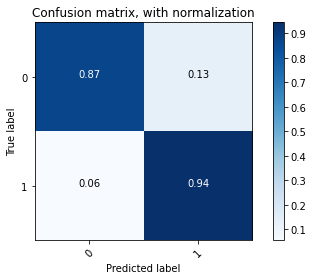

In [17]:
lstm_list=process_test(new_model2,30,train_it,val_it,test_it,0.001,"LSTM_tech_PN.pt")

## GRU results

Epoch :  5  Train Loss :  0.3612479666868846   Train Acc :  0.8448184430599213   Valid Loss :  0.30402658383051556  Val Acc :  0.8747717539469401
Epoch :  10  Train Loss :  0.20083428577830395   Train Acc :  0.9223422755797704   Valid Loss :  0.31991733113924664  Val Acc :  0.8964569369951884
Epoch :  15  Train Loss :  0.13947765373935303   Train Acc :  0.9462076822916666   Valid Loss :  0.31819961468378705  Val Acc :  0.9096033175786337
Epoch :  20  Train Loss :  0.10552223174211879   Train Acc :  0.9610188802083334   Valid Loss :  0.4436759253342946  Val Acc :  0.9025166829427084
Epoch :  25  Train Loss :  0.07946469021650653   Train Acc :  0.9695638020833334   Valid Loss :  0.3928137719631195  Val Acc :  0.9143356283505758
Epoch :  30  Train Loss :  0.05831694114021957   Train Acc :  0.9781087239583334   Valid Loss :  0.45192208886146545  Val Acc :  0.9079004526138306

Time needed for Training :  0.6839539607365926

Loss in Testset :  0.431907519698143   Accuracy in Testset :  0.904

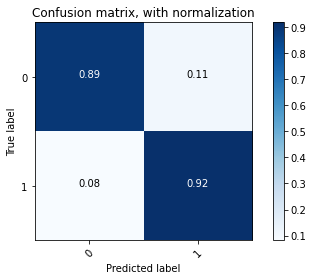

In [18]:
gru_list=process_test(new_model3,30,train_it,val_it,test_it,0.001,"GRU_tech_PN.pt")

## Evaluate Semantic Neutrals as Positive-Negative

In [19]:
def sentence(model, s):
    model.eval()
    
    token = [tok.text for tok in lang.tokenizer(s)]
    index = [TEXT.vocab.stoi[t] for t in token]
    tensor = torch.LongTensor(index).to(device)
    tensor = tensor.unsqueeze(0)
    pred = torch.sigmoid(model(tensor))
    return pred.item()

In [20]:
# LSTM
Neutral_pd = pd.read_csv("new_Neutral_Tech.csv")
train_pd = pd.read_csv("Train_Tech.csv")


for index, row in Neutral_pd.iterrows():
    st=str(Neutral_pd['Article'][index])
    v=sentence(new_model2,st)
    if v>0.9:
      Neutral_pd['Target'][index]=1.0
    elif v<0.1:
      Neutral_pd['Target'][index]=0.0
    else:
      Neutral_pd['Target'][index]=2.0


indexNames = Neutral_pd[Neutral_pd['Target'] == 2.0].index
 
# Delete these row indexes from dataFrame that were not classified as Positive or Negative
Neutral_pd.drop(indexNames , inplace=True)

print("\nNumber of Neutrals that might be not Neutrals by LSTM : ",len(Neutral_pd))

# GRU
Neutral_pd2 = pd.read_csv("new_Neutral_Tech.csv")
for index, row in Neutral_pd2.iterrows():
    v=sentence(new_model3,str(Neutral_pd2['Article'][index]))
    if v>0.9:
      Neutral_pd2['Target'][index]=1.0
    elif v<0.1:
      Neutral_pd2['Target'][index]=0.0
    else:
      Neutral_pd2['Target'][index]=2.0


indexNames = Neutral_pd2[Neutral_pd2['Target'] == 2.0].index
 
# Delete these row indexes from dataFrame
Neutral_pd2.drop(indexNames , inplace=True)

print("\nNumber of Neutrals that might be not Neutrals by GRU : ",len(Neutral_pd2))

Neutral_pd=Neutral_pd.merge(Neutral_pd2)

print("\nNumber of Neutrals that might be not Neutrals that agree LSTM and GRU : ",len(Neutral_pd))



Number of Neutrals that might be not Neutrals by LSTM :  736

Number of Neutrals that might be not Neutrals by GRU :  773

Number of Neutrals that might be not Neutrals that agree LSTM and GRU :  624


In [21]:
count1=(Neutral_pd['Target']==0).sum()
count2=(Neutral_pd['Target']==1).sum()

if count2>count1:
  count3=count2//count1-1
  count4=count2%count1
  Xnew=Neutral_pd[Neutral_pd['Target']==0]
else:
  count3=count1//count2-1
  count4=count1%count2
  Xnew=Neutral_pd[Neutral_pd['Target']==1]

for i in range(count3):
  Neutral_pd = pd.concat([Neutral_pd,Xnew], ignore_index=True)

Xnew=Xnew.head(count4)

Neutral_pd = pd.concat([Neutral_pd,Xnew], ignore_index=True)
Neutral_pd = pd.concat([train_pd,Neutral_pd], ignore_index=True)
print("Negative Examples in Training after OverSampling: ",(Neutral_pd ['Target']==0).sum())
print("Positive Examples in Training after OverSampling: ",(Neutral_pd ['Target']==1).sum())
Neutral_pd = Neutral_pd.sample(frac=1).reset_index(drop=True)

Neutral_pd.to_csv (r'new_Tech_train.csv', index = False, header=True)

Negative Examples in Training after OverSampling:  6080
Positive Examples in Training after OverSampling:  6080


## Retrain Models with new examples from Semantic Neutrals

In [22]:
torch.manual_seed(1234)
torch.backends.cudnn.deterministic = True

#TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
TEXT = data.Field(batch_first=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

fields = [('text',TEXT),('label', LABEL)]
X_train=data.TabularDataset(path = 'new_Tech_train.csv',format = 'csv',fields = fields,skip_header = True)
X_test=data.TabularDataset(path = 'Test_Tech.csv',format = 'csv',fields = fields,skip_header = True)
X_val=data.TabularDataset(path = 'Val_Tech.csv',format = 'csv',fields = fields,skip_header = True)

TEXT.build_vocab(X_train)  
LABEL.build_vocab(X_train)
train_it, val_it, test_it = data.BucketIterator.splits((X_train, X_val, X_test),sort_key = lambda x: len(x.text),
    sort_within_batch=True,batch_size = batch,device = device)

myInput = len(TEXT.vocab)
myEmbed = 300
myHid = 256
myOut = 1
batch=1024
train_it, val_it, test_it = data.BucketIterator.splits((X_train, X_val, X_test),sort_key = lambda x: len(x.text),
    sort_within_batch=True,batch_size = batch,device = device)  
dropout = 0.5

new_model4 = myLSTM(myInput, myEmbed, myHid, myOut,dropout)
new_model4.to(torch.device(device))
new_model5 = myGRU(myInput, myEmbed, myHid, myOut,dropout)
new_model5.to(torch.device(device))


myGRU(
  (embedding): Embedding(9626, 300)
  (rnn): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

## LSTM results after learning "Neutrals"

Epoch :  5  Train Loss :  0.3221810658772786   Train Acc :  0.863362635175387   Valid Loss :  0.30266260107358295  Val Acc :  0.8837113181749979
Epoch :  10  Train Loss :  0.19676923379302025   Train Acc :  0.921398346622785   Valid Loss :  0.3348693648974101  Val Acc :  0.8845377961794535
Epoch :  15  Train Loss :  0.10886185678342979   Train Acc :  0.958996002872785   Valid Loss :  0.3679345150788625  Val Acc :  0.9048705895741781
Epoch :  20  Train Loss :  0.0730445251489679   Train Acc :  0.9730166494846344   Valid Loss :  0.44034279386202496  Val Acc :  0.9003382325172424
Epoch :  25  Train Loss :  0.0534867603952686   Train Acc :  0.9815848271052042   Valid Loss :  0.5027694503466288  Val Acc :  0.9054463704427084
Epoch :  30  Train Loss :  0.042640778546532   Train Acc :  0.9848516583442688   Valid Loss :  0.5173023839791616  Val Acc :  0.9093276858329773

Time needed for Training :  0.9733501593271892

Loss in Testset :  0.4525048981110255   Accuracy in Testset :  0.90099671483

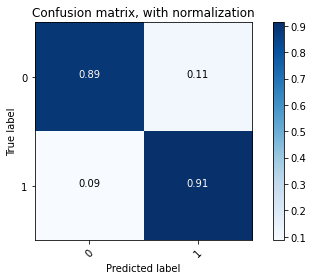

In [23]:
lstm_list2=process_test(new_model4,30,train_it,val_it,test_it,0.001,"LSTM_tech_PN2.pt")

## GRU results after learning "Neutrals"

Epoch :  5  Train Loss :  0.33165586988131207   Train Acc :  0.8576660205920538   Valid Loss :  0.31000280380249023  Val Acc :  0.8797547618548075
Epoch :  10  Train Loss :  0.20063257838288942   Train Acc :  0.9228166888157526   Valid Loss :  0.31047584613164264  Val Acc :  0.8977087140083313
Epoch :  15  Train Loss :  0.13153176630536714   Train Acc :  0.9494163890679678   Valid Loss :  0.3489229381084442  Val Acc :  0.9020660320917765
Epoch :  20  Train Loss :  0.09491626483698686   Train Acc :  0.9639369448026022   Valid Loss :  0.3772415618101756  Val Acc :  0.9088017741839091
Epoch :  25  Train Loss :  0.08212724576393764   Train Acc :  0.967366541425387   Valid Loss :  0.3916792968908946  Val Acc :  0.910880446434021
Epoch :  30  Train Loss :  0.05854616003731886   Train Acc :  0.978108728925387   Valid Loss :  0.49941309293111164  Val Acc :  0.9036686817804972

Time needed for Training :  0.7678510030110677

Loss in Testset :  0.4265818198521932   Accuracy in Testset :  0.90788

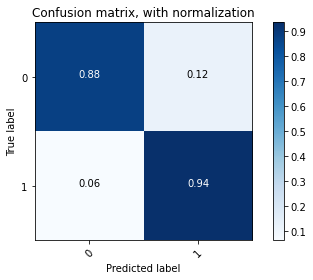

In [24]:
gru_list2=process_test(new_model5,30,train_it,val_it,test_it,0.001,"GRU_tech_PN2.pt")